# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn
warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(np.dot(-X, weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        regularization_term = (1 / (2 * self.C)) * np.linalg.norm(weights)
        return np.log(1 + np.exp(-np.dot(weights, x.T) * y)).mean() + regularization_term
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = -np.dot(X_ext.T, (y * (1 - 1 / (1 + np.exp(-np.dot(self.weights_, X_ext.T) * y))))) / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

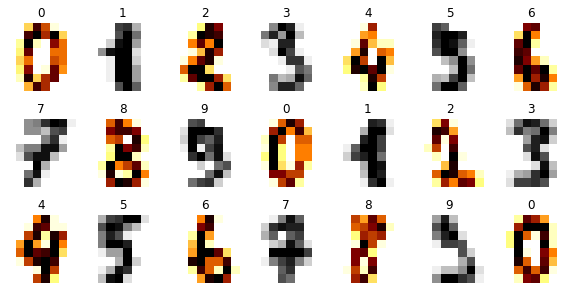

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

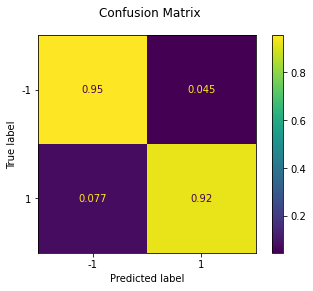

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

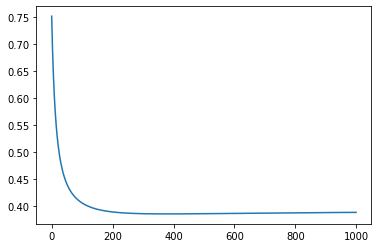

In [17]:
plt.plot(model.loss_history);

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

The default value for ETA is 0.001, and we see the plot for our model above. Let's fit_evaluate model for 1, 0.1, 0.01 and 0.0001 learning rates. 

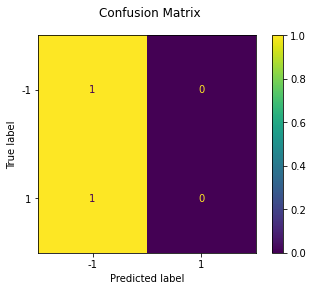

(0.4968684759916493, 0.49166666666666664)

In [18]:
model = CustomLogisticRegression(eta = 1)
fit_evaluate(model, X_train, y_train, X_test, y_test)

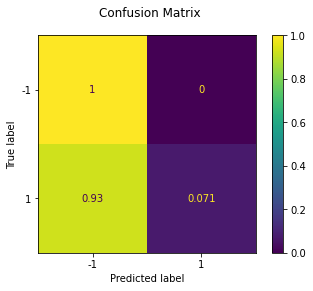

(0.5455810716771051, 0.5277777777777778)

In [19]:
model = CustomLogisticRegression(eta = 0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)

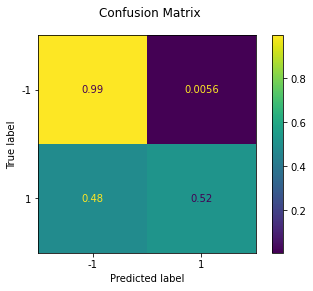

(0.7731384829505915, 0.7527777777777778)

In [20]:
model = CustomLogisticRegression(eta = 0.01)
fit_evaluate(model, X_train, y_train, X_test, y_test)

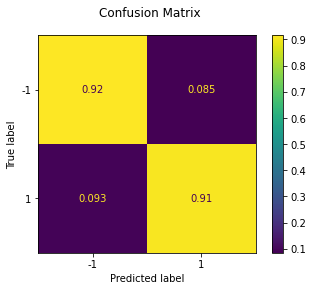

(0.8844815588030619, 0.9111111111111111)

In [21]:
model = CustomLogisticRegression(eta = 0.0001)
fit_evaluate(model, X_train, y_train, X_test, y_test)

> As we see, finding a correct learning rate is important. The learning rate determines how rapidly we update the parameters. If the learning rate is too large, we may "overshoot" the optimal value, i.e. we will never reach global minima. However, if the learning rate is set to be too small, we will need too many iterations to converge to the best values. 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

The default value for regularization parameter is set to 1.0, and we see the plot for our model above. Let's fit_evaluate model for setting the C to 10, 0.5, 0.1 and 0.01 learning rates. 

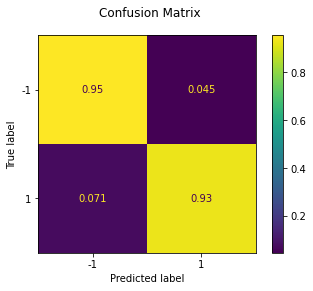

(0.9151009046624913, 0.9416666666666667)

In [22]:
model = CustomLogisticRegression(C = 10)
fit_evaluate(model, X_train, y_train, X_test, y_test)

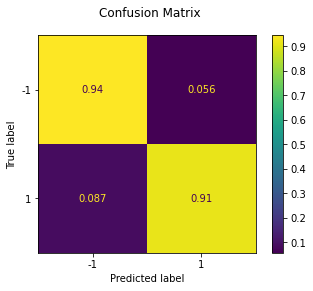

(0.9039665970772442, 0.9277777777777778)

In [23]:
model = CustomLogisticRegression(C = 0.5)
fit_evaluate(model, X_train, y_train, X_test, y_test)

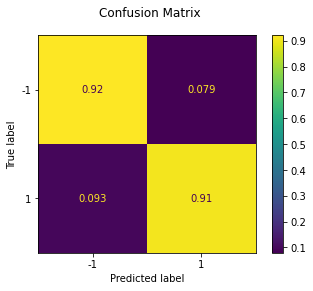

(0.8879610299234516, 0.9138888888888889)

In [24]:
model = CustomLogisticRegression(C = 0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)

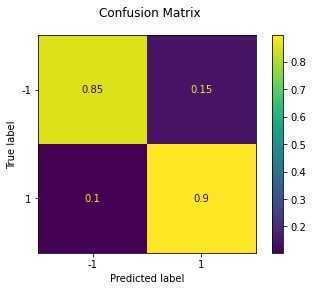

(0.8455114822546973, 0.875)

In [25]:
model = CustomLogisticRegression(C = 0.01)
fit_evaluate(model, X_train, y_train, X_test, y_test)

> As we see, lesser regularisation parameter leads to lesser accuracy, because our model starts to overfit. When creating a model it is important to find an optimal regularisation parameter, that will prevent our model both from over- and underfitting. Based on the plots above, **C = 10** can be considered as an optimal value compared to default 1.0

**(0.5 points)** Compare zero initialization and random initialization. 

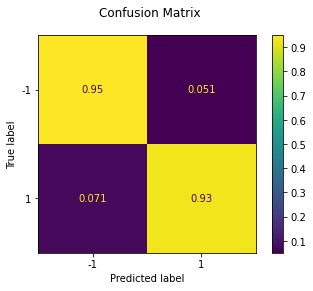

(0.9116214335421016, 0.9388888888888889)

In [26]:
model = CustomLogisticRegression(zero_init = True)
fit_evaluate(model, X_train, y_train, X_test, y_test)

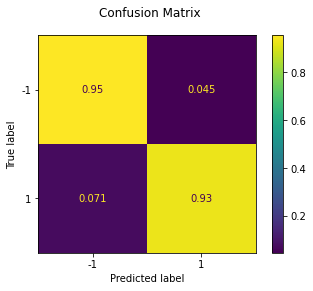

(0.9116214335421016, 0.9416666666666667)

In [27]:
model = CustomLogisticRegression(random_state = 0)
fit_evaluate(model, X_train, y_train, X_test, y_test)

> In our example, the difference is not significant.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [28]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return sklearn.metrics.pairwise.euclidean_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        res = []
        for i in self.classes_:
            sum = 0
            for j in range(len(y)):
                if y[j] == i:
                    sum = sum + weights[j]
            res.append(sum)
        return res
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            closest_distances = P.argsort(axis=1)[:, :self.n_neighbors]
            smallest_distances = P[np.arange(len(P))[:,None], closest_distances]
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(smallest_distances, self.eps)
            label_count = []
            for i in range(len(P)):
                label_count.append(self.get_class_weights(self.y[closest_distances][i], weights_of_points[i]))
            return np.array(np.array(label_count) / np.expand_dims(np.array(label_count).sum(axis=1), 1))
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")

    def predict(self, X):
        """Predict classes..
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis = 1)

In [29]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [30]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

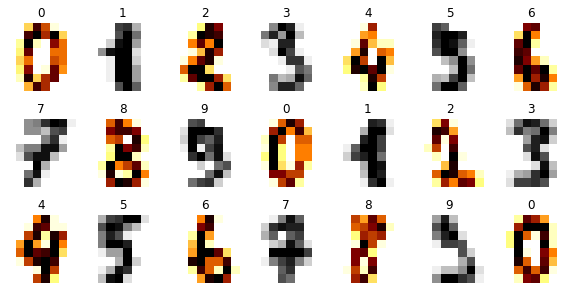

In [32]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [33]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [34]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

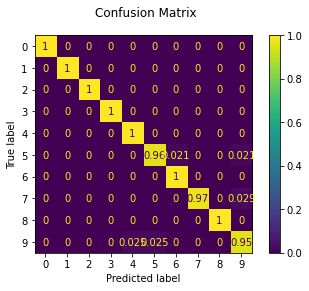

In [35]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [36]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

> In the confusion matrix we can observe some confusion around following pairs: 5/6, 5/9, 7/9, 9/4 and 9/5. It is happening because the shape of these digits is similar to the other digit in the pair (a curve and a bar element).

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

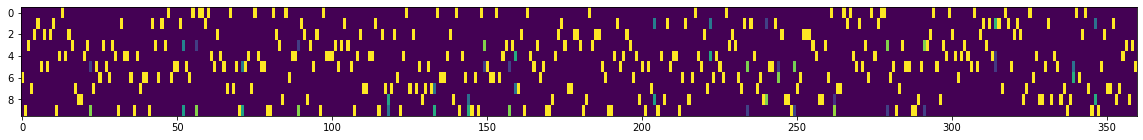

In [37]:
model = CustomKNeighborsClassifier(n_neighbors = 5, weights = 'distance')
model.fit(X_train, y_train)
plt.figure(figsize=(20, 2))
plt.imshow(pd.DataFrame(model.predict_proba(X_test)).T, interpolation = 'nearest', aspect = 'auto')

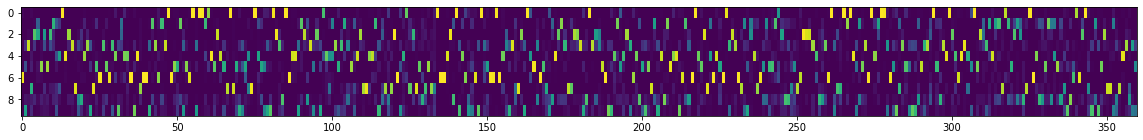

In [38]:
model = CustomKNeighborsClassifier(n_neighbors = 100, weights = 'distance')
model.fit(X_train, y_train)
plt.figure(figsize=(20, 2))
plt.imshow(pd.DataFrame(model.predict_proba(X_test)).T, interpolation= 'nearest', aspect = 'auto')

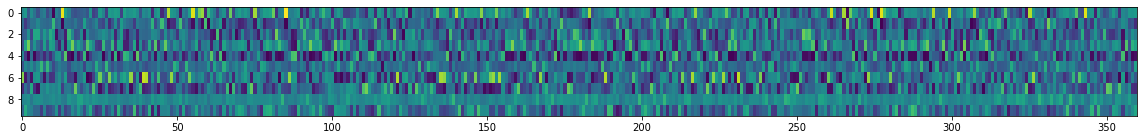

In [39]:
model = CustomKNeighborsClassifier(n_neighbors = 1000, weights = 'distance')
model.fit(X_train, y_train)
plt.figure(figsize=(20, 2))
plt.imshow(pd.DataFrame(model.predict_proba(X_test)).T, interpolation = 'nearest', aspect = 'auto')

> Selecting an optimal number of neighbours will allow us to get maximum accuracy for the training dataset with a low error rate. However, it can happen that accuracy might become too high due to overfitting and underfitting as training data may be very small. In our plots, we can see that increasing number of neighbours from default 5 to 100 and 1000 reduces the accuracy (the plot becomes extremely noisy/less gradient).

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

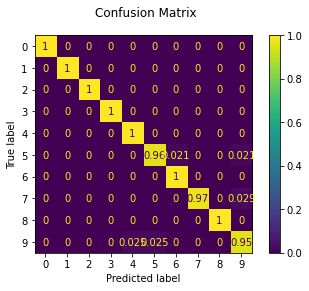

(1.0, 0.9861111111111112)

In [40]:
model = CustomKNeighborsClassifier(weights = 'distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

> In case of our model, the difference between using uniform and distanse weights is not observable in confusion matrices. However, when using uniform weighting, we do not take into account the distance between the new data point and its k nearest neighbors, thus all the neighbors impact the prediction equally. With distance weights, we might have gotten in a situation where the impact of some close neighbours will impact the prediction in a higher degree leading to overfitting of the model.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

> Euclidean or Manhattan as suggested and evaluated in this paper: https://www.csd.uwo.ca/~watt/pub/reprints/2009-ijdar-similarity.pdf

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

> Text mining and Jaccard Similarity (src. https://towardsdatascience.com/3-basic-distance-measurement-in-text-mining-5852becff1d7)

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [41]:
PATH = "../input/tabular-playground-series-apr-2021/train.csv" # Solved on Kaggle
PATH_TEST = "../input/tabular-playground-series-apr-2021/test.csv"

In [42]:
data = pd.read_csv(PATH, index_col="PassengerId")

In [43]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Total passengers: 
100000

Sex
female    43886
male      56114
dtype: int64

Survived
0    57226
1    42774
dtype: int64



<AxesSubplot:xlabel='Sex', ylabel='Survived'>

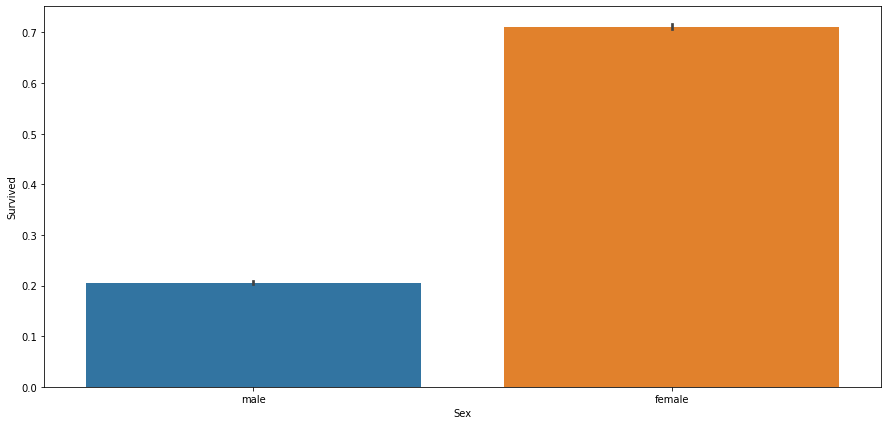

In [44]:
print("Total passengers: \n" + str(data.shape[0]) + "\n")
print(str(data[['Sex']].groupby(['Sex']).size()) + "\n")
print(str(data[['Survived']].groupby(['Survived']).size()) + "\n")

plt.figure(figsize=(15,7))
sns.barplot(data = data, x = 'Sex', y = 'Survived')

> - There are total 56114 men and 43886 women on the ship.
> - 57226 passenger have survived.
> - Women have a significantly higher survival rate than men.


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:ylabel='Count'>

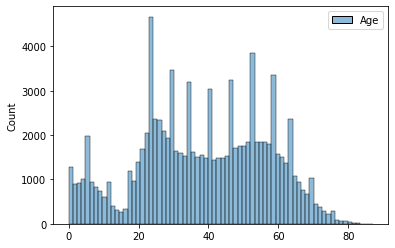

In [45]:
data.loc[data['Age'] < 1, 'Age'] = 0
data['Age'] = data['Age'].round(0)
sns.histplot(data[['Age']])

In [46]:
print("Mean age of passengers: " + str(data['Age'].mean())),
print("Median age of passengers: " + str(data['Age'].median()))

Mean age of passengers: 38.35213219175249
Median age of passengers: 39.0


<AxesSubplot:ylabel='Age'>

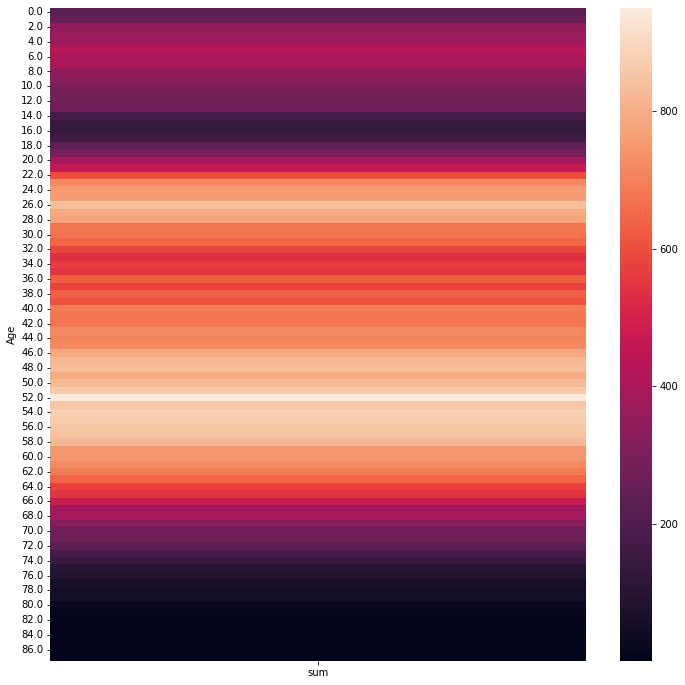

In [47]:
plt.figure(figsize=(12,12))
sns.heatmap(data.groupby(['Age'])['Survived'].agg(['sum']))

> Yes, the age distribution differ between survived and not survived passengers. Most likely this is due to the rescue principle that kids and seniors have a priority.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

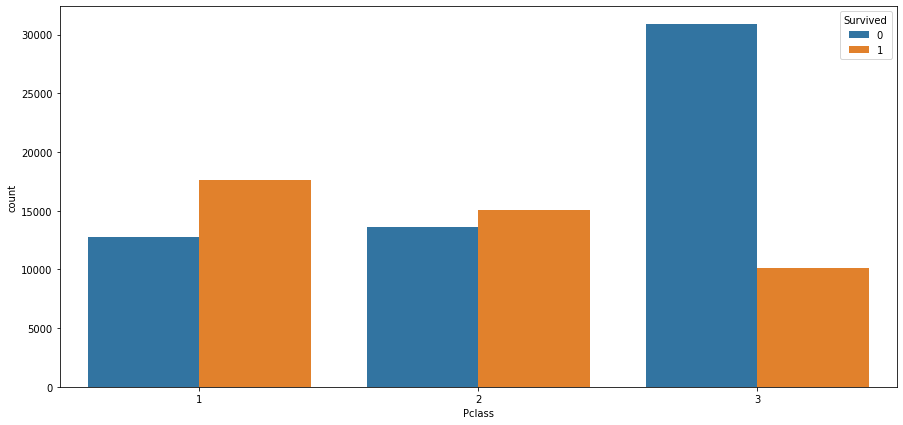

In [48]:
plt.figure(figsize=(15,7))
sns.countplot(data = data, x = 'Pclass', hue = 'Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

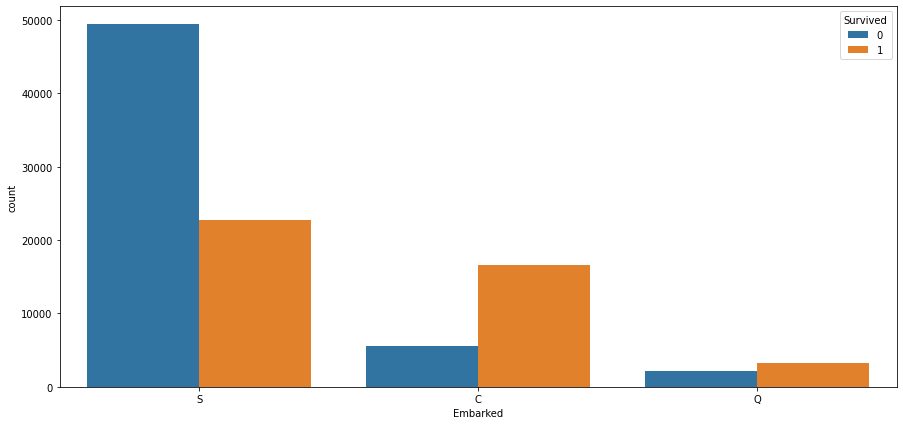

In [49]:
plt.figure(figsize=(15,7))
sns.countplot(data = data, x = 'Embarked', hue = 'Survived')

> - 1st class was the one where the survival rate was the highest.
> - If a passenger has embarked in Southampton chances for survival were the lowest.
> - Majority of passengers have embarked in Southampton.


### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [50]:
data.isna().mean() * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

> I would suggest to fill in the missing numerical values, like **Age**, with mean values. For categorical values like Embarked, we could do some deeper analysis and try to predict the **Embarked** port based on **Fare/Ticket**.
> We could also use prediction based on non-NaN values, e.g., Survived/Sex/Parch to identify missing values with some probability.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.0,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.0,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.0,0,0,427635,7.76,NaN,S


In [52]:
train = pd.read_csv(PATH)
test = pd.read_csv(PATH_TEST)

def feature_prep(df):
    df = df.copy()
    
    # Age
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df.loc[data['Age'] < 1, 'Age'] = 0
    df['Age'] = df['Age'].round(0)
    
    # SibSp + Parch cobmined
    df['SibSp_Parch'] = df['SibSp'] + df['Parch']
    df['SibSp_Parch'] = pd.cut(df['SibSp_Parch'], bins=[0 , np.round(df['SibSp_Parch'].max() / 4, 0) , np.round(df['SibSp_Parch'].max() / 2, 0) , df['SibSp_Parch'].max()])
    
    # Fare
    df['Fare'] = df.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.mean()))
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # Get dummies
    df = pd.get_dummies(df, columns=['Pclass','Sex','Embarked', 'SibSp_Parch'])
    
    # Return by dropping features that are considered non-essential for survival rate at the moment
    return df.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1)

feature_prep(train)

,PassengerId,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,"SibSp_Parch_(0.0, 4.0]","SibSp_Parch_(4.0, 8.0]","SibSp_Parch_(8.0, 17.0]"
0,0,1,39.0,27.14,1,0,0,0,1,0,0,1,1,0,0
1,1,0,39.0,13.35,0,0,1,0,1,0,0,1,0,0,0
2,2,0,0.0,71.29,0,0,1,0,1,0,0,1,1,0,0
3,3,0,19.0,13.04,0,0,1,0,1,0,0,1,0,0,0
4,4,1,25.0,7.76,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,62.0,14.86,0,1,0,1,0,1,0,0,0,0,0
99996,99996,0,66.0,11.15,0,1,0,0,1,0,0,1,0,0,0
99997,99997,0,37.0,9.95,0,0,1,0,1,0,0,1,0,0,0
99998,99998,0,51.0,30.92,0,0,1,0,1,0,0,1,1,0,0


In [53]:
X_train = feature_prep(train).drop(['PassengerId', 'Survived'], axis=1)
Y_train = feature_prep(train)['Survived']

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[ 0.03477526, -0.24138976,  1.51614545, ...,  1.34261388,
        -0.14238266, -0.06937618],
       [ 0.03477526, -0.43965957, -0.65956733, ..., -0.74481578,
        -0.14238266, -0.06937618],
       [-2.12986745,  0.39338994, -0.65956733, ...,  1.34261388,
        -0.14238266, -0.06937618],
       ...,
       [-0.07623206, -0.48854408, -0.65956733, ..., -0.74481578,
        -0.14238266, -0.06937618],
       [ 0.70081917, -0.18704169, -0.65956733, ...,  1.34261388,
        -0.14238266, -0.06937618],
       [ 0.92283381, -0.43088912, -0.65956733, ..., -0.74481578,
        -0.14238266, -0.06937618]])

In [55]:
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)
cross_val_score(model_lr, X_train, Y_train, scoring='accuracy').mean()

0.7627200000000001

In [56]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, Y_train)
cross_val_score(model_knn, X_train, Y_train, scoring='accuracy').mean()

0.7344299999999999

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [57]:
X_test = feature_prep(test)

survived = X_test[['PassengerId']].copy()
survived['Survived'] = model_lr.predict(X_test.drop(['PassengerId'], axis = 1))
survived.to_csv('./submit.csv', index=False)

# Score on Kaggle: 0.76889

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.